* https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
* https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
* https://github.com/soumith/ganhacks

In [1]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.utils import save_image
#########################
seed = 2
cuda = torch.cuda.is_available()
# torch.cuda.empty_cache()
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic=True
#########################
snapshot_folder = 'simpson_weights_model2'
test_folder = 'simpson_test2'
batch_size = 32 # lower BS can be beneficial
image_size = 128
init_lr = 0.0002
latent_dim = 100
low_dim_rep = 8
decay_rate = 0.96
EPSILON = 0.00005

device = torch.device('cuda' if cuda else 'cpu')
assert device.type == 'cuda'

In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

### Loading the data

In [3]:
def get_data(size= 32):
    train_data_dir = '/home/chris/GEN_AI_WORKSPACE/MTech_projects_IIT/IMAGE_GENERATION(GENAI)/Simpson-face-generator-DCGAN-pytorch/simpsons_dataset'

    train_tfms = transforms.Compose([
                                     transforms.Resize((size, size)),
                                     transforms.RandomHorizontalFlip(p=0.5),
#                                      transforms.RandomRotation(degrees=10),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                                 ])
    
    train_set = datasets.ImageFolder(train_data_dir, transform= train_tfms)
    train_loader = DataLoader(train_set,batch_size = batch_size, shuffle= True, num_workers = 8)
  
    return train_loader 

In [4]:
train_loader= get_data(image_size)
num_class = len(train_loader.dataset.classes)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  51744
number of batches:  1617


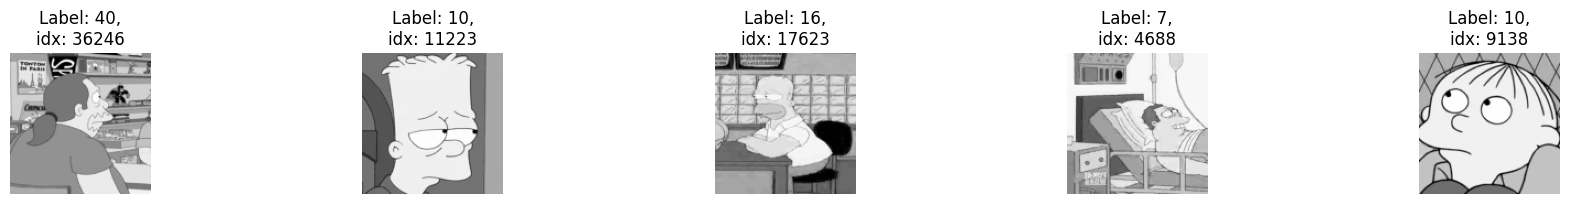

In [5]:
# in order to display images with this function, comment out the normalize() in the data loader transforms
import random
def plot_gallery(imgs,image_size,num=5,class_idx=False):
    plt.figure(figsize=(20,6))
    for idx in range(num) :
        if class_idx:
            i = idx
        else:
            rand = random.randint(1,len(imgs))
            i = idx+rand
        img_ = imgs[i][0]
        label = imgs[i][1]
        plt.subplot(1, num, idx+1)
        plt.axis('off')
        plt.imshow(img_[1].reshape(img_.shape[2],img_.shape[1]),cmap='Greys_r')
        plt.subplots_adjust(wspace=1.5)
        plt.title("Label: {0},\nidx: {1}".format(label,i))

plot_gallery(train_loader.dataset,image_size,class_idx=False)

### Discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

In [6]:
def generate_fake_sample(size):
    X = torch.rand(size, 3, image_size ,image_size).to(device, dtype=torch.float)
    return X

In [7]:
def binary_accuracy(output, target, reverse=False):
    """Computes the accuracy for multiple binary predictions"""
    pred = torch.reshape(output >= 0.5,(1,len(output)))
    truth = torch.reshape(target < 0.5,(1,len(target)))
    acc = ((pred == truth).sum()).item() / len(target)* 100
    return acc 

In [8]:
# we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
            
        )
        self.fc = nn.Sequential(
            nn.Linear(low_dim_rep*low_dim_rep*1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, low_dim_rep*low_dim_rep*1024)
        x = self.fc(x)
        return x

In [9]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True

In [10]:
discriminator(torch.zeros((batch_size,3,128,128)).to(device)).shape

torch.Size([32, 1])

In [11]:
criterion = lambda output, target: F.binary_cross_entropy(input=output,target=target)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=init_lr, betas = (0.5,0.999))

### Generator

In [12]:
def generate_latent_vector(size):
    z = torch.randn(size, latent_dim).to(device)
    return z

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, low_dim_rep*low_dim_rep*1024), # 100 is the length of our latent vector. 100 is kind of a best practice number.
            nn.LeakyReLU(0.2)
        )
        
        # The Conv2DTranspose layer can be configured with a stride of (2×2) 
        # that will quadruple the area of the input feature maps (double their width and height dimensions). 
        # It is also good practice to use a kernel size that is a factor of the stride
        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, stride=2, padding=1, output_padding=0), # output = > 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=0), # output = > 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=0), # output = > 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1), # output = >  128x128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(64, 3, 5, stride=1, padding=1), # bigger conv layer for smoothness
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 1024, low_dim_rep, low_dim_rep)
        x = self.cnn(x)
        return x

In [14]:
torch.cuda.empty_cache()
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=65536, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [15]:
generator(generate_latent_vector(batch_size)).shape 

torch.Size([32, 3, 128, 128])

In [16]:
optimizer_g = torch.optim.Adam(generator.parameters(), lr=init_lr, betas = (0.5,0.999))

### Train

In [17]:
gen_loss=[]
dis_loss=[]
best_loss = np.inf
tolarance = 200

In [18]:
import time
torch.cuda.empty_cache()

num_epochs = 1000

for ep in range(0,num_epochs):

    start=time.time()
    print("Epoch :",ep,'\n')
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device, dtype=torch.float)
        
        # dont't forget to change the real labels for generator
        labels_fake = (((torch.rand(len(images))+1)/2)+0.2).to(device, dtype=torch.float) # labels  0.7 - 1.2   
        labels_real = ((torch.rand(len(images)))/3).to(device, dtype=torch.float)  # labels  0 - 0.3
    
        rnd_indexes = set(np.random.randint(len(images), size=int(0.05*len(images))))
        
        # flip the labels of 5% of the data for disciminator only
        for i in rnd_indexes:
            labels_real[i] = ((labels_real[i]+1)/2)+0.2
            labels_fake[i] = labels_fake[i]/3 - 0.1
            
        # Train the discriminator, it tries to discriminate between real and fake (generated) samples
        discriminator.zero_grad()
        outputs_re = discriminator(images)
        loss_real = criterion(outputs_re, labels_real)

        z = generate_latent_vector(len(images))
        images_fake = generator(z)
        outputs_fe = discriminator(images_fake.detach())
        loss_fake = criterion(outputs_fe, labels_fake)

        loss_d = loss_real + loss_fake              # Calculate the total loss
        loss_d.backward()                           # Backpropagation
        optimizer_d.step()                          # Update the weights

        # Train the generator, it tries to fool the discriminator
        # Draw samples from the input distribution and pass to generator
        z = generate_latent_vector(len(images))
        images_fake = generator(z)
        # Pass the genrated images to discriminator
        outputs_fe_gen = discriminator(images_fake)

        generator.zero_grad()
        
        labels_real = (torch.zeros(len(images))).to(device, dtype=torch.float) # hard labels for the generator with no noise
        loss_g = criterion(outputs_fe_gen, labels_real)    # Calculate the loss
        loss_g.backward()                                  # Backpropagation
        optimizer_g.step()                                 # Update the weights
     
        if n % (25) == 0:
            print('batch: {} - loss_d: {:.4f} - loss_g: {:.4f} - loss_real: {:.4f} - loss_fake: {:.4f}'.format
                  (n, loss_d.item(), loss_g.item(),loss_real.item(),loss_fake.item()))
    
    print('\nD_loss: {}; G_loss: {}'.format(loss_d.item(), loss_g.item()))

    # Save the test results after each Epoch
    torch.save(generator.state_dict(), snapshot_folder+'/model_gen_'+str(ep)+'.pth')
    torch.save(generator.state_dict(), snapshot_folder+'/model_dis_'+str(ep)+'.pth')

    test_name = test_folder+'/ep'+str(ep)+'.png'
    
    test = generator(generate_latent_vector(len(images)))[i]
    save_image((test+ 1) / 2.0, test_name)
    
    dis_loss.append(loss_d.item())
    gen_loss.append(loss_g.item())
    end= time.time()
    
    print('Lowest G loss:', min(gen_loss))
    
    if ep % 10 == 0:
        plt.figure(figsize=(4,4))
        plt.title('Loss')
        plt.plot(gen_loss)
        plt.plot(dis_loss)
        plt.legend(['generator','discriminator'])
        plt.show()

    print('\nTook: ', end-start, ' seconds')
    print('='*80)

Epoch : 0 



ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[18], line 27
     25 discriminator.zero_grad()
     26 outputs_re = discriminator(images)
---> 27 loss_real = criterion(outputs_re, labels_real)
     29 z = generate_latent_vector(len(images))
     30 images_fake = generator(z)

Cell In[11], line 1
----> 1 criterion = lambda output, target: F.binary_cross_entropy(input=output,target=target)
      2 optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=init_lr, betas = (0.5,0.999))

File /media/chris/UBUNTU_PARTITION/anaconda3/envs/dualstylegan_env/lib/python3.8/site-packages/torch/nn/functional.py:3163, in binary_cross_entropy(input, target, weight, size_average, reduce, reduction)
   3161     reduction_enum = _Reduction.get_enum(reduction)
   3162 if target.size() != input.size():
-> 3163     raise ValueError(
   3164         f"Using a target size ({target.size()}) that is different to the input size ({input.size()}) is deprecated. "
   3165         "Please ensure they have the same size."
   3166     )
   3168 if weight is not None:
   3169     new_size = _infer_size(target.size(), weight.size())

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.






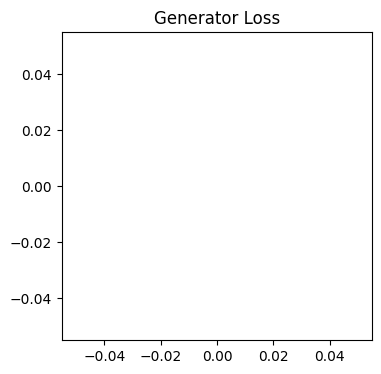

In [ ]:
plt.figure(figsize=(4,4))
plt.title('Generator Loss')
plt.plot(gen_loss)
plt.show()

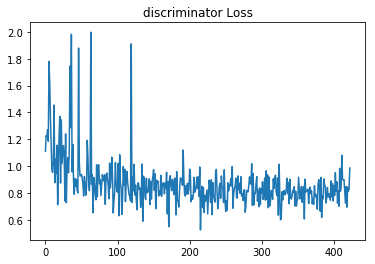

In [20]:
plt.title('discriminator Loss')
plt.plot(dis_loss)
plt.show()

In [21]:
minl=np.inf
for i,g in enumerate(gen_loss):
    if g<minl:
        minl=g
        minidx=i
minidx,minl

(63, 0.5382052063941956)